<h1><center>Regional Universities (North) Ranking</center></h1>
<center>__Junyan Huang__</center>

# Introduction

This proejct aims to build a predictive model for regional universities (north) rankings.

# Data Cleaning

The data is corrected manually from USNews (https://www.usnews.com/best-colleges/rankings/regional-universities-north).
In the data set, there are 28 columns and 170 rows (before cleaning) and 160 rows (after cleaning). Due to the manual error during the process of data collection, the raw data set needs quite a lot of cleaning. The data cleaning process includes correcting typing errors, unifying data types within attributes, etc. After cleaning the data, the attribute types are various. Some are numeric, such as "Endowment Amount (dollars)", some are string, such as "School Name", some are categorical, such as "School type (private/public)".

In [290]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [291]:
colleges_raw = pd.read_csv("Regional_Colleges_Ranking.csv", header=1)

In [292]:
colleges_raw = colleges_raw.drop(["Unnamed: 0", "Unnamed: 1", "Unnamed: 2", "Unnamed: 3"], axis=1)

In [293]:
pd.set_option("display.max_columns", 100)

In [294]:
colleges_raw.head(20)

,School Ranking,School Name,School type (private/public),School type (coed/same),Year Founded,Religious Affiliation,Setting,Endowment Amount (dollars),Tutition and Fees (In State),Room and Board,Total Enrollment,Median starting salary of alumni,Number of majors,Classes with fewer 20 students,Classes with 20-49 students,Classes with 50+ students,Student Faculty Ratio,4-year graduation rate,Student Gender Distribution (male:female),Collegiate athletic association,Students receiving financial aid (%),Average need-based scholarship or grant,Total criminal offenses (on campus),Students who have cars on campus,Health insurance offered,Acceptance Rate,SAT/ACT Scores Used,Application Admission Type (Deadline/rolling)
0,1,Fairfield University,private,coed,1942.00,Roman Catholic,Suburban,"349,300,000","48,350","14,710","5,192","55,600",40.00,0.439,0.553,0.008,12:1,0.79,41:00:00,1,0.45,"27,572",18.00,0.42,yes,0.65,yes,Deadline
1,2,Providence College,private,coed,1917.00,Roman Catholic,City,"221,100,000","50,390","14,700","4,306","53,300",50.00,0.537,0.436,0.002,12:1,0.8,45:55:00,1,0.47,"27,621",13.00,0.11,yes,0.52,yes,Deadline
2,3,Bentley University,private,coed,1917.00,None,Suburban,"27,180,000","49,880","16,320","4,272","61,500",11.00,0.194,0.806,0.01,11:1,0.87,59:41:00,2,0.44,"32,947",16.00,0.9,yes,0.44,yes,Deadline
3,4,College of New Jersey,public,coed,1855.00,None,Suburban,"37,400,000","16,551","13,617","7,552","55,000",10.00,0.439,0.558,0.003,13:1,0.73,42:58:00,3,0.5,"11,601",50.00,NaN,yes,0.48,yes,Deadline
4,5,Loyola University Maryland,private,coed,1852.00,roman Catholic,urban,"214,900,000","49,085","14,430",5783,"55,000",30.00,0.466,0.529,0.004,11:1,0.77,42:58:00,1,0.53,"21,247",18.00,0.24,yes,0.75,NaN,Deadline
5,6,Emerson College,private,coed,1880.00,None,urban,"161,100,000","46,852","17,690","4,466","45,500",9.00,0.674,0.313,0.012,13:1,0.77,41:59:00,3,0.54,"19,004",9.00,NaN,yes,0.46,yes,Deadline
6,6,University of Scranton,private,coed,1888.00,roman Catholic,City,"187,200,000","44,532","15,182","5,373","52,000",8.00,0.529,0.47,0.01,12:1,0.72,42:58:00,3,0.69,"23,408",9.00,0.25,no,0.75,yes,Deadline
7,8,Marist College,private,coed,1929.00,None,Suburban,"64,700,000","39,600","15,550","6,657","51,200",12.00,0.43,0.57,0.01,16:1,0.75,42:58:00,1,0.58,"16,425",12.00,NaN,yes,0.43,yes,Deadline
8,9,Ithaca College,private,coed,1892.00,None,Suburban,"300,700,000","43,978","15,562","6,059","47,000",12.00,0.606,0.366,0.028,10:1,0.69,42:58:00,3,0.68,"27,622",22.00,0.51,yes,0.71,yes,Deadline
9,10,Bryant University,private,coed,1863.00,None,Suburban,NaN,"43,973","15,702","3,751","55,900",11.00,0.22,0.78,0.01,13:1,0.73,61:39:00,1,0.61,"10,287",18.00,0.5,yes,0.73,yes,Deadline


In [295]:
colleges_raw.shape

(170, 28)

In [296]:
colleges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 28 columns):
School Ranking                                   170 non-null object
School Name                                      160 non-null object
School type (private/public)                     160 non-null object
School type (coed/same)                          160 non-null object
Year Founded                                     158 non-null float64
Religious Affiliation                            160 non-null object
Setting                                          158 non-null object
Endowment Amount (dollars)                       145 non-null object
Tutition and Fees
(In State)                     160 non-null object
Room and Board                                   155 non-null object
Total Enrollment                                 154 non-null object
Median starting salary of alumni                 146 non-null object
Number of majors                                 146 non-null floa

In [297]:
all_empty_row_indices = colleges_raw[colleges_raw["School Name"].isnull()].index

In [298]:
all_empty_row_indices

Int64Index([120, 121, 122, 123, 124, 125, 126, 127, 128, 129], dtype='int64')

In [299]:
colleges_raw = colleges_raw.drop(index=all_empty_row_indices)

In [300]:
colleges_raw = colleges_raw.reset_index()

In [301]:
colleges_raw.shape

(160, 29)

In [302]:
ranking_correct = {6:6, 15:15, 20:20, 25:25, 26:25, 28:28, 29:28, 30:28, 31:28, 32:28, 33:28, 35:35, 36:35, 37:35, 38:35, 
           39:35, 50:50, 51:50, 52:50, 53:50, 54:55, 55:55, 56:55, 57:55, 58:55, 59:55, 60:55,
           60: 55, 61: 62, 62: 62, 63:62, 64:62, 65:62, 66:67, 67:68, 68:68, 69:68,
           101:99, 102:99, 103:103, 105:105, 106:105, 107:105, 108:105, 109:105, 110:105, 112:112, 113:112, 114:112, 
          115:112, 117:117, 118:117, 130:126, 132:132, 133:132, 134:132, 135:132, 137:137, 139:139, 140:139}

In [303]:
ranking = np.array(colleges_raw["School Ranking"])

In [304]:
len(ranking)

160

In [305]:
ranking

array(['1', '2', '3', '4', '5', '6', '6', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '41', '43', '43', '43',
       '43', '43', '48', '49', '50', '50(tie)', '50(tie)', '50(tie)',
       '50(tie)', '55(tie)', '55(tie)', '55(tie)', '55(tie)', '55(tie)',
       '55(tie)', '55 (tie)', '62 (tie)', '62 (tie)', '62 (tie)',
       '62 (tie)', '62 (tie)', '67', '68 (tie)', '68 (tie)', '68 (tie)',
       '68', '68', '68', '74', '74', '74', '74', '74', '74', '74', '81',
       '81', '81', '81', '81', '81', '87', '87', '87', '90', '90', '90',
       '93', '93', '93', '93', '93', '93', '99', '99', '101', '102',
       '103', '104', '105', '106', '107', '108', '109', '110', '111',
       '112', '113', '114', '115', '116', '117', '118', '119', '120',
       '131', '132', '133', '134', '135', '136', '137', '138', '139',
    

In [306]:
# Collect the ranking numbers
for key, value in ranking_correct.items():
    ranking[key] = value

In [307]:
ranking

array(['1', '2', '3', '4', '5', '6', 6, '8', '9', '10', '11', '12', '13',
       '14', '15', 15, '17', '18', '19', '20', 20, '22', '23', '24', '25',
       25, 25, '28', 28, 28, 28, 28, 28, 28, '35', 35, 35, 35, 35, 35,
       '41', '41', '43', '43', '43', '43', '43', '48', '49', '50', 50, 50,
       50, 50, 55, 55, 55, 55, 55, 55, 55, 62, 62, 62, 62, 62, 67, 68, 68,
       68, '68', '68', '68', '74', '74', '74', '74', '74', '74', '74',
       '81', '81', '81', '81', '81', '81', '87', '87', '87', '90', '90',
       '90', '93', '93', '93', '93', '93', '93', '99', '99', '101', 99,
       99, 103, '105', 105, 105, 105, 105, 105, 105, '112', 112, 112, 112,
       112, '117', 117, 117, '120', '131', '132', '133', '134', '135',
       '136', '137', '138', '139', '140', 126, '142', 132, 132, 132, 132,
       '147', 137, '149', 139, 139, '152', '153', '154', '155', '156',
       '157', '158', '159', '160', '161', '162', '163', '164', '165',
       '166', '167', '168', '169', '170'], dtype=obje

In [308]:
ranking = ranking.astype(np.int)

In [309]:
colleges_raw["School Ranking"] = pd.Series(ranking)

In [310]:
colleges_raw = colleges_raw.drop("index", axis=1)

In [311]:
colleges_raw["School Ranking"] = colleges_raw["School Ranking"].astype(int)

In [312]:
school_type = colleges_raw["School type (private/public)"].unique()

In [313]:
for index, row in colleges_raw["School type (private/public)"].items():
    row = row.strip().lower().capitalize()
    colleges_raw.iloc[index, 2]=row
colleges_raw["School type (private/public)"].unique()

array(['Private', 'Public', 'Priavte'], dtype=object)

In [314]:
school_type_correct = {"Priavte":"Private"}

In [315]:
colleges_raw=colleges_raw.replace({"School type (private/public)":school_type_correct})

In [316]:
colleges_raw["School type (private/public)"].unique()

array(['Private', 'Public'], dtype=object)

In [317]:
colleges_raw["School type (private/public)"] = colleges_raw["School type (private/public)"].astype('category')

In [318]:
colleges_raw["School type (coed/same)"].unique()

array(['coed', 'Same', ' Coed', 'Coed', 'same', 'Code'], dtype=object)

In [319]:
coed_same_correct = {"coed": "Coed", " Coed": "Coed", "same":"Same", "Code":"Coed"}

In [320]:
colleges_raw=colleges_raw.replace({"School type (coed/same)":coed_same_correct})

In [321]:
colleges_raw["School type (coed/same)"].unique()

array(['Coed', 'Same'], dtype=object)

In [322]:
colleges_raw["School type (coed/same)"] = colleges_raw["School type (coed/same)"].astype('category')

In [323]:
colleges_raw["Religious Affiliation"].unique()

array(['Roman Catholic', 'None', 'roman Catholic', 'Undiminational',
       'United Methodist', 'Other', 'United Church of Christ',
       'Reformed Presbyterian Church', 'none', 'roman catholic',
       'american baptist', 'presbyterian', 'free methodist',
       'American Baptist', 'Episcopal Church, Reformed',
       'Church of the Nazarene'], dtype=object)

In [324]:
religious_correct={"roman Catholic": "Roman Catholic", "none":"None", "roman catholic":"Roman Catholic", 
                  "american baptist": "American Baptist", "presbyterian":"Presbyterian", 
                  "free methodist": "Free Methodist"}

In [325]:
colleges_raw=colleges_raw.replace({"Religious Affiliation":religious_correct})

In [326]:
colleges_raw["Religious Affiliation"].unique()

array(['Roman Catholic', 'None', 'Undiminational', 'United Methodist',
       'Other', 'United Church of Christ', 'Reformed Presbyterian Church',
       'American Baptist', 'Presbyterian', 'Free Methodist',
       'Episcopal Church, Reformed', 'Church of the Nazarene'],
      dtype=object)

In [327]:
colleges_raw["Religious Affiliation"] = colleges_raw["Religious Affiliation"].astype('category')

In [328]:
colleges_raw["Setting"].unique()

array(['Suburban', 'City', 'urban', 'Urban', 'Rural', 'suburban', 'city',
       'rural', nan, '\r\nSuburban'], dtype=object)

In [329]:
setting_correct = {"urban": "Urban", "suburban":"Suburban", "city":"City", "rural":"Rural", "\r\nSuburban":"Suburban"}

In [330]:
colleges_raw=colleges_raw.replace({"Setting":setting_correct})

In [331]:
colleges_raw["Setting"].unique()

array(['Suburban', 'City', 'Urban', 'Rural', nan], dtype=object)

In [332]:
colleges_raw["Setting"] = colleges_raw["Setting"].astype('category')

In [333]:
colleges_raw["Endowment Amount (dollars)"] = colleges_raw["Endowment Amount (dollars)"].astype(str)

In [334]:
colleges_raw["Endowment Amount (dollars)"].unique()

array(['349,300,000', '221,100,000', '27,180,000', '37,400,000',
       '214,900,000', '161,100,000', '187,200,000', '64,700,000',
       '300,700,000', 'nan', '188,000,000', '234.000,000',
       '$481,000,000.00', '28,000,000', '90,000,000', '$873,000,000.00',
       '$179,000,000', '5,000,000', '20,000,000', '172,000,000',
       '$179.1 million +', '$66.8 million', '$123.8 million',
       '$60.5 million', '$120.0 million +', '$79.0 million +',
       '$36.1 million +', '$102.5 million +', '$90.3 million +',
       '56,300,000', '59,900,000', '72,300,000', '48,700,000',
       '85,100,000', '49,200,000', '65,700,000', '58,700,000',
       '157,500,000', '26,800,000', '50,300,000', '20,400,000',
       '91,300,000', '37,700,000', '98,000,000', '67,600,000',
       '83,000,000', '60,200,000', '32,900,000', '54,400,000',
       '110,500,000', '37,800,000', '31,100,000', '76,000,000',
       '69,500,000', '289,000,000', '80,100,000', '77,800,000',
       '49,100,000', '$28,700,000.00',

In [335]:
for index, row in colleges_raw["Endowment Amount (dollars)"].items():
    if str(row).find("million")!=-1:
        row = float(re.findall("\d+\.\d+", row)[0])*1000000
        colleges_raw.iat[index, 7] = row
    if str(row).find("$")!=-1:
        #print(row)
        row = row.replace("$", "")
        #print(row)
        colleges_raw.iat[index, 7] = row

In [336]:
for index, row in colleges_raw["Endowment Amount (dollars)"].items():
    if row != "nan":
        colleges_raw.iat[index, 7] = str(row).replace(",", "")

In [337]:
colleges_raw["Endowment Amount (dollars)"] = pd.to_numeric(colleges_raw["Endowment Amount (dollars)"], errors="coerce")

In [338]:
for index, row in colleges_raw["Endowment Amount (dollars)"].items():
    if row < 100:
        colleges_raw.iat[index, 7] = row*1000000

In [339]:
colleges_raw["Endowment Amount (dollars)"].unique()

array([3.49300e+08, 2.21100e+08, 2.71800e+07, 3.74000e+07, 2.14900e+08,
       1.61100e+08, 1.87200e+08, 6.47000e+07, 3.00700e+08,         nan,
       1.88000e+08, 2.34000e+02, 4.81000e+08, 2.80000e+07, 9.00000e+07,
       8.73000e+08, 1.79000e+08, 5.00000e+06, 2.00000e+07, 1.72000e+08,
       1.79100e+08, 6.68000e+07, 1.23800e+08, 6.05000e+07, 1.20000e+08,
       7.90000e+07, 3.61000e+07, 1.02500e+08, 9.03000e+07, 5.63000e+07,
       5.99000e+07, 7.23000e+07, 4.87000e+07, 8.51000e+07, 4.92000e+07,
       6.57000e+07, 5.87000e+07, 1.57500e+08, 2.68000e+07, 5.03000e+07,
       2.04000e+07, 9.13000e+07, 3.77000e+07, 9.80000e+07, 6.76000e+07,
       8.30000e+07, 6.02000e+07, 3.29000e+07, 5.44000e+07, 1.10500e+08,
       3.78000e+07, 3.11000e+07, 7.60000e+07, 6.95000e+07, 2.89000e+08,
       8.01000e+07, 7.78000e+07, 4.91000e+07, 2.87000e+07, 1.18600e+08,
       7.77000e+07, 8.33000e+07, 3.18000e+07, 9.41000e+07, 3.70000e+07,
       1.30800e+08, 2.88000e+07, 7.30000e+07, 4.77000e+07, 8.500

In [340]:
colleges_raw.iloc[:, 8].unique()

array(['48,350', '50,390', '49,880', '16,551', '49,085', '46,852',
       '44,532', '39,600', '43,978', '43,973', '$40,800', '$44,974',
       '$47,960', '$8,651', '$42,608', '$40,501', '$34,625', '$8,332',
       '$8,381', '$7,921', '$17,038', '$34,301', '$28,488', '$43,650',
       '$6,980', '$33,050', '$31,490', '$39,600', '$38,138', '$14,108',
       '14,835', '40,150', '37,445', '35,066', '30,710', '33,240',
       '34,280', '42,860', '41,420', '13,739', '41,350', '8,254',
       '39,492', '34,910', '33,180', '34,512', '47,090', '32,136',
       '8,440', '41,760', '36,890', '35,748', '8,286', '9,940', '43,580',
       '7,048', '7,138', '37,400', '37,226', '8,421', '$39,173.00',
       '$33,484.00', '$37,611.00', '$41,427.00', '$27,845.00',
       '$35,973.00', '$27,230.00', '$38,812.00', '$38,070.00',
       '$8,300.00', '$21,882', '$36,804', '$36,194', '$34,715', '18,510',
       '32,882', '32,441', '40,016', '17,733', '37,620', '41010', '14212',
       '36900', '37486', '36182',

In [341]:
for index, row in colleges_raw.iloc[:, 8].items():
    colleges_raw.iat[index, 8] = str(row).replace(",", "")

In [342]:
for index, row in colleges_raw.iloc[:, 8].items():
    if str(row).find("$")!=-1:
        row = row.replace("$", "")
        colleges_raw.iat[index, 8] = row

In [343]:
colleges_raw.iloc[:, 8].unique()

array(['48350', '50390', '49880', '16551', '49085', '46852', '44532',
       '39600', '43978', '43973', '40800', '44974', '47960', '8651',
       '42608', '40501', '34625', '8332', '8381', '7921', '17038',
       '34301', '28488', '43650', '6980', '33050', '31490', '38138',
       '14108', '14835', '40150', '37445', '35066', '30710', '33240',
       '34280', '42860', '41420', '13739', '41350', '8254', '39492',
       '34910', '33180', '34512', '47090', '32136', '8440', '41760',
       '36890', '35748', '8286', '9940', '43580', '7048', '7138', '37400',
       '37226', '8421', '39173.00', '33484.00', '37611.00', '41427.00',
       '27845.00', '35973.00', '27230.00', '38812.00', '38070.00',
       '8300.00', '21882', '36804', '36194', '34715', '18510', '32882',
       '32441', '40016', '17733', '37620', '41010', '14212', '36900',
       '37486', '36182', '24820', '9824', '8221', '8164', '7980', '15428',
       '10205', '11356', '31568', '30857', '39270', '13060', '20100',
       '32060', 

In [344]:
colleges_raw.iloc[:, 8] = pd.to_numeric(colleges_raw.iloc[:, 8])

In [345]:
colleges_raw.iloc[:, 9].unique()

array(['14,710', '14,700', '16,320', '13,617', '14,430', '17,690',
       '15,182', '15,550', '15,562', '15,702', '$15,200', '$14,840',
       '$14,540', '$13,610', '$16,220', '$13,465', '$13,780', '$13,886',
       '$12,306', '$15,178', '$14,100', '$12,170', '$11,300', '$11,860',
       '$10,573', '$15,276', '$15,032', '$12,684', '$13,981', '$12,204',
       '12,336', '14,500', '12,550', '11,928', '15,080', '13,960',
       '13,730', '15,280', '15,310', '12,282', '13,075', '13,462',
       '12,700', '13,900', '13,200', '15,516', '14,124', '12,650',
       '14,140', '15,845', '14,290', '14,368', '12,590', '12,464',
       '13,800', nan, '15,998', '12,800', '12,940', '13,205',
       '$11,428.00', '$12,516.00', '$12,090.00', '$13,370.00',
       '$14,190.00', '$10,170.00', '$15,278.00', '$12,880.00',
       '$12,810.00', '$8,494', '$13,590', '$14,682', '$12,025', '11,254',
       '12,267', '13,840', '12,522', '13,990', '15354', '11008', '11850',
       '15414', '13130', '10160', '11950'

In [346]:
for index, row in colleges_raw.iloc[:, 9].items():
    if str(row).find("$")!=-1:
        row = row.replace("$", "")
        colleges_raw.iat[index, 9] = row

In [347]:
for index, row in colleges_raw.iloc[:, 9].items():
    if row !="nan":
        colleges_raw.iat[index, 9] = str(row).replace(",", "")

In [348]:
colleges_raw.iloc[:, 9].unique()

array(['14710', '14700', '16320', '13617', '14430', '17690', '15182',
       '15550', '15562', '15702', '15200', '14840', '14540', '13610',
       '16220', '13465', '13780', '13886', '12306', '15178', '14100',
       '12170', '11300', '11860', '10573', '15276', '15032', '12684',
       '13981', '12204', '12336', '14500', '12550', '11928', '15080',
       '13960', '13730', '15280', '15310', '12282', '13075', '13462',
       '12700', '13900', '13200', '15516', '14124', '12650', '14140',
       '15845', '14290', '14368', '12590', '12464', '13800', 'nan',
       '15998', '12800', '12940', '13205', '11428.00', '12516.00',
       '12090.00', '13370.00', '14190.00', '10170.00', '15278.00',
       '12880.00', '12810.00', '8494', '13590', '14682', '12025', '11254',
       '12267', '13840', '12522', '13990', '15354', '11008', '11850',
       '15414', '13130', '10160', '11950', '12830', '12988', '13410',
       '10850', '10312', '13520', '10628', '12618', '15900', '11445',
       '11200', '13400'

In [349]:
colleges_raw.iloc[:, 9] = pd.to_numeric(colleges_raw.iloc[:, 9], errors= "coerce")

In [350]:
colleges_raw.iloc[:, 9].unique()

array([14710., 14700., 16320., 13617., 14430., 17690., 15182., 15550.,
       15562., 15702., 15200., 14840., 14540., 13610., 16220., 13465.,
       13780., 13886., 12306., 15178., 14100., 12170., 11300., 11860.,
       10573., 15276., 15032., 12684., 13981., 12204., 12336., 14500.,
       12550., 11928., 15080., 13960., 13730., 15280., 15310., 12282.,
       13075., 13462., 12700., 13900., 13200., 15516., 14124., 12650.,
       14140., 15845., 14290., 14368., 12590., 12464., 13800.,    nan,
       15998., 12800., 12940., 13205., 11428., 12516., 12090., 13370.,
       14190., 10170., 15278., 12880., 12810.,  8494., 13590., 14682.,
       12025., 11254., 12267., 13840., 12522., 13990., 15354., 11008.,
       11850., 15414., 13130., 10160., 11950., 12830., 12988., 13410.,
       10850., 10312., 13520., 10628., 12618., 15900., 11445., 11200.,
       13400., 13106., 12714., 14520., 13440., 14130., 11690., 12799.,
       11442., 12179., 11000., 12200., 14975., 10500., 11906., 12268.,
      

In [351]:
colleges_raw["Total Enrollment"].unique()

array(['5,192', '4,306', '4,272', '7,552', '5783', '4,466', '5,373',
       '6,657', '6,059', '3,751', '6,402', '8,085', '10,256', '5,591',
       '4,242', '7,547', '3,431', '2,933', '1,780', '18,289', '1,578',
       '2,089', '3,464', '1,910', '23,005', '5,057', '4,980', '2,334',
       '6,340', '6,120', '6,853', '2,823', '3,241', '2,681', '5,197',
       '2,764', '2,900', '5,073', '8,543', '9,216', '2,323', '7,565',
       '2,112', '2,950', '3,949', '5024', '2,289', '4,149', '8,026',
       '4,171', '7,403', '2,048', '4,631', '22,705', '3,811', '16,222',
       '19,866', '3,315', '2,468', '6,358', '2,405', '2,345', '2,269',
       '11,358', '5,142', '4,457', '1,599', '3,792', '2,777', '6,913',
       '17,306', '3813', '5,545', '2,200', '17803', '3,291', '8,564',
       '4,114', '1,794', '8,281', '3037', '3866', '2475', '3524', '3876',
       '1736', '8714', '3587', '5719', '8313', '6310', '7638', '5073',
       '1321', '1320', '5216', '8838', '4171', '1128', '1174', '3950',
       '1

In [352]:
for index, row in colleges_raw["Total Enrollment"].items():
    colleges_raw.iloc[index, 10] = str(row).replace(",", "")

In [353]:
for index, row in colleges_raw["Total Enrollment"].items():
    if row == "\r\nN/A":
        colleges_raw.iloc[index, 10]=np.nan 

In [354]:
colleges_raw["Total Enrollment"] = pd.to_numeric(colleges_raw["Total Enrollment"], errors="coerce")

In [355]:
colleges_raw["Median starting salary of alumni"].unique()

array(['55,600', '53,300', '61,500', '55,000', '45,500', '52,000',
       '51,200', '47,000', '55,900', '$50,200', '$53,200', '$53,000',
       '$46,300', '$62,000', '$69,500', '$45,700', '$49,400', '$63,600',
       '$54,400', '$39,800', '$42,600', '$43,000', '$46,200', '$48,800',
       '$46,700', '$62,300', '$50,400', '$48,400', '$47,500', '49,000',
       '49,700', '41,200', '43,700', '52,400', '43,100', '40,500',
       '47,200', '52,200', '43,600', '44,100', '44,400', '43,000',
       '41,500', '41,700', '50,600', '52,300', '49,600', '42,000',
       '53,500', '55,200', '42,700', '40,100', '47,300', '41,300',
       '53,900', '47,700', '46,900', '$43,900.00', '$50,400.00',
       '$49,800.00', '$40,200.00', '$48,000.00', '$43,500.00',
       '$60,400.00', '$44,900.00', '$51,000.00', '$42,900.00',
       '$43,000.00', '$46,000', '$55,000', '51,600', '46400', '42300',
       '45,100', '56,300', '68,100', '50,200', '47500', '47600', '45900',
       '46000', '45600', '44200', '47300'

In [356]:
for index, row in colleges_raw["Median starting salary of alumni"].items():
    colleges_raw.iloc[index, 11] = str(row).replace(",", "")

In [357]:
for index, row in colleges_raw["Median starting salary of alumni"].items():
    if str(row).find("$")!=-1:
        row = row.replace("$", "")
        colleges_raw.iat[index, 11] = row

In [358]:
colleges_raw["Median starting salary of alumni"] = pd.to_numeric(colleges_raw["Median starting salary of alumni"], 
                                                                 errors="coerce")

In [359]:
for index, row in colleges_raw["Median starting salary of alumni"].items():
    if row <1000:
        colleges_raw.iat[index, 11] = row*1000

In [360]:
#colleges_raw[colleges_raw["Number of majors"]<10]["Number of majors"]

In [361]:
colleges_raw["Classes with fewer 20 students"].unique()

array(['0.439', '0.537', '0.194', '0.466', '0.674', '0.529', '0.43',
       '0.606', '0.22', '0.68', '0.406', '0.431', '0.283', '0.449',
       '0.696', '0.434', '0.38', '0.2', '97.20%', '53.80%', '55.20%',
       '62%', '37.70%', '60.50%', '67%', '49.60%', '39.70%', '39.20%',
       '0.444', '0.388', '0.454', '0.661', '0.464', '0.477', '0.517',
       '0.474', '0.41', '0.266', '0.554', '0.245', '0.721', '0.575',
       '0.57', '0.479', '0.663', '0.532', '0.549', '0.645', '0.619',
       '0.577', '0.285', '0.657', '0.323', '0.344', '0.572', '0.547',
       '0.335', '0.769', '0.665', '0.653', '0.706', '0.369', '0.669',
       '0.32', '0.545', '0.297', '0.26', '0.576', '0.644', '0.305',
       '0.882', '0.476', '0.357', '0.403', '0.539', '0.63', '0.54',
       '0.896', '0.614', '0.691', '0.33', '0.39', '0.292', '0.497',
       '0.158', '0.343', '0.69', '0.668', '0.518', '0.914', '0.766',
       '67.9', '70.9', '31.5', '46.6', '64.4', '87.6', '72.1', '40.1',
       '85.4', '74.4', nan, '0

In [362]:
for index, row in colleges_raw["Classes with fewer 20 students"].items():
    if str(row).find("%")!=-1:
        colleges_raw.iat[index, 13] =  float(row.replace("%", ""))*0.01

In [363]:
colleges_raw["Classes with fewer 20 students"] = pd.to_numeric(colleges_raw["Classes with fewer 20 students"], 
                                                              errors="coerce")

In [364]:
for index, row in colleges_raw["Classes with fewer 20 students"].items():
    if row >1:
        colleges_raw.iloc[index, 13] = row/100

In [365]:
colleges_raw["Classes with fewer 20 students"].unique()

array([0.439, 0.537, 0.194, 0.466, 0.674, 0.529, 0.43 , 0.606, 0.22 ,
       0.68 , 0.406, 0.431, 0.283, 0.449, 0.696, 0.434, 0.38 , 0.2  ,
       0.972, 0.538, 0.552, 0.62 , 0.377, 0.605, 0.67 , 0.496, 0.397,
       0.392, 0.444, 0.388, 0.454, 0.661, 0.464, 0.477, 0.517, 0.474,
       0.41 , 0.266, 0.554, 0.245, 0.721, 0.575, 0.57 , 0.479, 0.663,
       0.532, 0.549, 0.645, 0.619, 0.577, 0.285, 0.657, 0.323, 0.344,
       0.572, 0.547, 0.335, 0.769, 0.665, 0.653, 0.706, 0.369, 0.669,
       0.32 , 0.545, 0.297, 0.26 , 0.576, 0.644, 0.305, 0.882, 0.476,
       0.357, 0.403, 0.539, 0.63 , 0.54 , 0.896, 0.614, 0.691, 0.33 ,
       0.39 , 0.292, 0.497, 0.158, 0.343, 0.69 , 0.668, 0.518, 0.914,
       0.766, 0.679, 0.709, 0.315, 0.876, 0.401, 0.854, 0.744,   nan,
       0.519, 0.771, 0.347, 0.7  , 0.382, 0.273, 0.422, 0.534, 0.459,
       0.712, 0.781, 0.515, 0.424, 0.242, 0.773, 0.317, 0.778, 0.46 ,
       0.318, 0.218, 0.58 , 0.452, 0.662, 0.637, 0.411, 0.681, 0.604,
       0.754, 0.592,

In [366]:
colleges_raw["Classes with 20-49 students"].unique()

array(['0.553', '0.436', '0.806', '0.558', '0.529', '0.313', '0.47',
       '0.57', '0.366', '0.78', '0.28', '0.583', '0.543', '0.66', '0.55',
       '0.269', '0.554', '0.451', '0.605', '0.63', '2.80%', '46.20%',
       '44.80%', '36.10%', '55.70%', '39.50%', '30.60%', '50.40%',
       '60.20%', '60.80%', '0.461', '0.61', '0.522', '0.339', '0.523',
       '0.483', '0.515', '0.577', '0.714', '0.446', '0.71', '0.279',
       '0.421', '0.419', '0.516', '0.319', '0.465', '0.396', '0.606',
       '0.345', '0.37', '0.373', '0.682', '0.287', '0.64', '0.573',
       '0.407', '0.453', '0.625', '0.227', '0.306', '0.327', '0.284',
       '0.335', '0.617', '0.303', '0.679', '0.452', '0.645', '0.68',
       '0.423', '0.397', '0.342', '0.651', '0.116', '0.524', '0.608',
       '0.578', '0.403', '0.104', '0.425', '0.385', '0.3', '0.637',
       '0.568', '0.503', '0.744', '0.657', '0.29', '0.332', '0.538',
       '0.477', '0.482', '0.086', '0.234', '32', '28.9', '62.8', '49.2',
       '33.7', '12.4', 

In [367]:
for index, row in colleges_raw["Classes with 20-49 students"].items():
    if str(row).find("%")!=-1:
        colleges_raw.iat[index, 14] = float(row.replace("%", ""))*0.01   

In [368]:
colleges_raw["Classes with 20-49 students"] = pd.to_numeric(colleges_raw["Classes with 20-49 students"], 
                                                              errors="coerce")

In [369]:
for index, row in colleges_raw["Classes with 20-49 students"].items():
    if row >1:
        colleges_raw.iloc[index, 14] = row/100

In [370]:
colleges_raw["Classes with 20-49 students"].unique()

array([0.553, 0.436, 0.806, 0.558, 0.529, 0.313, 0.47 , 0.57 , 0.366,
       0.78 , 0.28 , 0.583, 0.543, 0.66 , 0.55 , 0.269, 0.554, 0.451,
       0.605, 0.63 , 0.028, 0.462, 0.448, 0.361, 0.557, 0.395, 0.306,
       0.504, 0.602, 0.608, 0.461, 0.61 , 0.522, 0.339, 0.523, 0.483,
       0.515, 0.577, 0.714, 0.446, 0.71 , 0.279, 0.421, 0.419, 0.516,
       0.319, 0.465, 0.396, 0.606, 0.345, 0.37 , 0.373, 0.682, 0.287,
       0.64 , 0.573, 0.407, 0.453, 0.625, 0.227, 0.327, 0.284, 0.335,
       0.617, 0.303, 0.679, 0.452, 0.645, 0.68 , 0.423, 0.397, 0.342,
       0.651, 0.116, 0.524, 0.578, 0.403, 0.104, 0.425, 0.385, 0.3  ,
       0.637, 0.568, 0.503, 0.744, 0.657, 0.29 , 0.332, 0.538, 0.477,
       0.482, 0.086, 0.234, 0.32 , 0.289, 0.628, 0.492, 0.337, 0.124,
       0.277, 0.567, 0.146, 0.252,   nan, 0.481, 0.224, 0.624, 0.674,
       0.464, 0.531, 0.288, 0.215, 0.39 , 0.409, 0.473, 0.569, 0.678,
       0.711, 0.629, 0.222, 0.521, 0.654, 0.721, 0.42 , 0.514, 0.338,
       0.356, 0.513,

In [371]:
for index, row in colleges_raw["Classes with 50+ students"].items():
    if str(row).find("<")!=-1:
        colleges_raw.iat[index, 15] = row.replace("<", "")
    if str(row).find("%")!=-1:
        colleges_raw.iat[index, 15] = row.replace("%", "")
    if str(row) == "N/A\n":
        colleges_raw.iat[index, 15] = np.nan

In [372]:
colleges_raw["Classes with 50+ students"].unique()

array(['0.008', '0.002', '0.01', '0.003', '0.004', '0.012', '0.028',
       '0.029', '0.011', '0.027', '0.102', '0.035', '0.013', '0.016',
       '0.165', '< 1', '1.90', '6.60', '2.50', '0.10', '0.095', '0.024',
       '0.02', '0.044', '0.005', '0.018', '0.054', '0.014', '0.051',
       '0.033', '0.055', '0.037', '0.084', '0.021', '0.04', '0.015',
       '0.03', '0.058', '0.06', '0.001', '0', '0.009', '0.042', '0.068',
       '0.098', '0.1', '0.2', '5.7', '4.2', '1.9', '1', '0.3', '3.2',
       '0.4', nan, '0.006', '0.007', '0.053', '0.08', '0.019', '0.114',
       '0.063', '0.076', '0.017'], dtype=object)

In [373]:
colleges_raw["Classes with 50+ students"] = pd.to_numeric(colleges_raw["Classes with 50+ students"], errors="coerce")

In [374]:
colleges_raw["Classes with 50+ students"].unique()

array([8.00e-03, 2.00e-03, 1.00e-02, 3.00e-03, 4.00e-03, 1.20e-02,
       2.80e-02, 2.90e-02, 1.10e-02, 2.70e-02, 1.02e-01, 3.50e-02,
       1.30e-02, 1.60e-02, 1.65e-01,      nan, 1.90e+00, 6.60e+00,
       2.50e+00, 1.00e-01, 9.50e-02, 2.40e-02, 2.00e-02, 4.40e-02,
       5.00e-03, 1.80e-02, 5.40e-02, 1.40e-02, 5.10e-02, 3.30e-02,
       5.50e-02, 3.70e-02, 8.40e-02, 2.10e-02, 4.00e-02, 1.50e-02,
       3.00e-02, 5.80e-02, 6.00e-02, 1.00e-03, 0.00e+00, 9.00e-03,
       4.20e-02, 6.80e-02, 9.80e-02, 2.00e-01, 5.70e+00, 4.20e+00,
       1.00e+00, 3.00e-01, 3.20e+00, 4.00e-01, 6.00e-03, 7.00e-03,
       5.30e-02, 8.00e-02, 1.90e-02, 1.14e-01, 6.30e-02, 7.60e-02,
       1.70e-02])

In [375]:
colleges_raw["Student Faculty Ratio"].unique()

array(['12:1', '11:1', '13:1', '16:1', '10:1', '19:1', '18:1', '7:1',
       '14:1', '14:1 ', '12:1 ', '11:1 ', '9:1 ', '17:1 ', '17:1', '14:0',
       '15:1', '9:1', '21:1', nan, '8:1', '20:1', '13:1 ', '15:1 ',
       '19:1 ', '15;1'], dtype=object)

In [376]:
for index, row in colleges_raw["Student Faculty Ratio"].items():
    if str(row).find(";")!=-1:
        colleges_raw.iloc[index, 16]= row.replace(";", ":") 

In [377]:
colleges_raw["Student Faculty Ratio"].unique()

array(['12:1', '11:1', '13:1', '16:1', '10:1', '19:1', '18:1', '7:1',
       '14:1', '14:1 ', '12:1 ', '11:1 ', '9:1 ', '17:1 ', '17:1', '14:0',
       '15:1', '9:1', '21:1', nan, '8:1', '20:1', '13:1 ', '15:1 ',
       '19:1 '], dtype=object)

In [378]:
for index, row in colleges_raw["Student Faculty Ratio"].items():
    colleges_raw.iloc[index, 16] = str(row).split(":")[0]

In [379]:
colleges_raw["Student Faculty Ratio"].unique()

array(['12', '11', '13', '16', '10', '19', '18', '7', '14', '9', '17',
       '15', '21', 'nan', '8', '20'], dtype=object)

In [380]:
colleges_raw["Student Faculty Ratio"] = pd.to_numeric(colleges_raw["Student Faculty Ratio"], errors="coerce")

In [381]:
colleges_raw["Student Faculty Ratio"].unique()

array([12., 11., 13., 16., 10., 19., 18.,  7., 14.,  9., 17., 15., 21.,
       nan,  8., 20.])

In [382]:
colleges_raw["4-year graduation rate"].unique()

array(['0.79', '0.8', '0.87', '0.73', '0.77', '0.72', '0.75', '0.69',
       '0.67', '0.76', '0.68', '0.59', '0.5', '0.64', '0.36', '0.58',
       '0.41', '24%', '59%', '62%', '69%', '71%', '51%', '68%', '57%',
       '60%', '0.25', '0.52', '0.71', '0.56', '0.55', '0.54', '0.6',
       '0.63', '0.53', '0', '0.3', '0.48', '0.47', '0.61', '0.12', '0.29',
       '0.62', '0.51', '0.45', '0.28', '0.57', nan, '0.38', '0.34',
       '0.44', '0.65', '0.27', '0.37', '46', '49', '36', '44', '53', '43',
       '24', '47', '0.33', '0.2', '0.32', '0.46', '0.35', '0.22', '0.39',
       '0.19', '0.26', '0.42', '0.4', '0.31', '0.08'], dtype=object)

In [383]:
for index, row in colleges_raw["4-year graduation rate"].items():
    if str(row).find("%")!=-1:
        colleges_raw.iloc[index, 17]=row.replace("%", "")

In [384]:
colleges_raw["4-year graduation rate"].unique()

array(['0.79', '0.8', '0.87', '0.73', '0.77', '0.72', '0.75', '0.69',
       '0.67', '0.76', '0.68', '0.59', '0.5', '0.64', '0.36', '0.58',
       '0.41', '24', '59', '62', '69', '71', '51', '68', '57', '60',
       '0.25', '0.52', '0.71', '0.56', '0.55', '0.54', '0.6', '0.63',
       '0.53', '0', '0.3', '0.48', '0.47', '0.61', '0.12', '0.29', '0.62',
       '0.51', '0.45', '0.28', '0.57', nan, '0.38', '0.34', '0.44',
       '0.65', '0.27', '0.37', '46', '49', '36', '44', '53', '43', '47',
       '0.33', '0.2', '0.32', '0.46', '0.35', '0.22', '0.39', '0.19',
       '0.26', '0.42', '0.4', '0.31', '0.08'], dtype=object)

In [385]:
for index, row in colleges_raw["4-year graduation rate"].items():
    if float(row)>1:
        colleges_raw.iloc[index, 17]=float(row)/100

In [386]:
colleges_raw["4-year graduation rate"].unique()

array(['0.79', '0.8', '0.87', '0.73', '0.77', '0.72', '0.75', '0.69',
       '0.67', '0.76', '0.68', '0.59', '0.5', '0.64', '0.36', '0.58',
       '0.41', 0.24, 0.59, 0.62, 0.69, 0.71, 0.51, 0.68, 0.57, 0.6,
       '0.25', '0.52', '0.71', '0.56', '0.55', '0.54', '0.6', '0.63',
       '0.53', '0', '0.3', '0.48', '0.47', '0.61', '0.12', '0.29', '0.62',
       '0.51', '0.45', '0.28', '0.57', nan, '0.38', '0.34', '0.44',
       '0.65', '0.27', '0.37', 0.46, 0.49, 0.36, 0.44, 0.53, 0.43, 0.47,
       '0.33', '0.2', '0.32', '0.46', '0.35', '0.22', '0.39', '0.19',
       '0.26', '0.42', '0.4', '0.31', '0.08'], dtype=object)

In [387]:
colleges_raw["4-year graduation rate"] = pd.to_numeric(colleges_raw["4-year graduation rate"], errors="coerce")

In [388]:
colleges_raw["4-year graduation rate"].unique()

array([0.79, 0.8 , 0.87, 0.73, 0.77, 0.72, 0.75, 0.69, 0.67, 0.76, 0.68,
       0.59, 0.5 , 0.64, 0.36, 0.58, 0.41, 0.24, 0.62, 0.71, 0.51, 0.57,
       0.6 , 0.25, 0.52, 0.56, 0.55, 0.54, 0.63, 0.53, 0.  , 0.3 , 0.48,
       0.47, 0.61, 0.12, 0.29, 0.45, 0.28,  nan, 0.38, 0.34, 0.44, 0.65,
       0.27, 0.37, 0.46, 0.49, 0.43, 0.33, 0.2 , 0.32, 0.35, 0.22, 0.39,
       0.19, 0.26, 0.42, 0.4 , 0.31, 0.08])

In [389]:
colleges_raw["Student Gender Distribution (male:female)"].unique()

array(['41:00:00', '45:55:00', '59:41:00', '42:58:00', '41:59:00',
       '61:39:00', '99:01:00', '46:54:00', '39:61:00:', '40:60:00:',
       '55:45:00:', '28:72:00:', '66:34:00:', '87:13:00:', '51:49:00:',
       '44:56:00', '52:48:00', '50:50:00', '36:05:00', '40:01:00',
       '26:15:00', '33:67:00:', '51:49:00', '37:63:00:', '26:74:00:',
       '42:58:00:', '36:64:00:', '48:52', '39:61', '38:62', '31:69',
       '47:53', '36:64', '43:57', '51:49', '49:51', '64:36', '42:58',
       '40:60', '45:55', '54:46', '2:98', '52:48', '24:76', '33:67',
       '79:21', '50:50', '44:56', '41:59', '63:37:00', '53:47:00',
       '33:08:00', '31:69:00', '40:60:00', '77:23:00', '88:12:00',
       '62:38:00', '5:95', '34:66', '57:43', '69:31', '53:47', '67:33',
       '75:25', '37:63', '28:13', '0:100', '16:84', nan, '27:73', '32:68',
       '1.954166667', '29:71', '58:42:00', '47:53:00', '37:04:00',
       '22:19:00', '25:16:00', '35:65:00:', '26:74:00:\r\n', '43:57:00',
       '29:71:00:', '23:18

In [390]:
for index, row in colleges_raw["Student Gender Distribution (male:female)"].items():
    if str(row).find(":") !=-1:
        male_num = str(row).split(":")[0]
        female_num = 100-float(male_num)
        ratio = round((float(male_num)/female_num), 2)
        colleges_raw.iloc[index, 18] = ratio
    if str(row).find(":") == -1:
        if str(row) == "1.954166667":
            ratio = round(float(row), 2)
            colleges_raw.iloc[index, 18] = ratio
        if str(row) == "34":
            ratio = round(float(row)/(100-float(row)), 2)
            colleges_raw.iloc[index, 18] = ratio

In [391]:
colleges_raw["Student Gender Distribution (male:female)"].unique()

array([0.69, 0.82, 1.44, 0.72, 1.56, 99.0, 0.85, 0.64, 0.67, 1.22, 0.39,
       1.94, 6.69, 1.04, 0.79, 1.08, 1.0, 0.56, 0.35, 0.49, 0.59, 0.92,
       0.61, 0.45, 0.89, 0.75, 0.96, 1.78, 1.17, 0.02, 0.32, 3.76, 1.7,
       1.13, 3.35, 7.33, 1.63, 0.05, 0.52, 1.33, 2.23, 2.03, 3.0, 0.0,
       0.19, nan, 0.37, 0.47, 1.95, 0.41, 1.38, 0.28, 0.33, 0.54, 0.3],
      dtype=object)

In [392]:
colleges_raw["Student Gender Distribution (male:female)"]=pd.to_numeric(colleges_raw["Student Gender Distribution (male:female)"],
                                                                       errors="coerce")

In [393]:
colleges_raw[colleges_raw["Collegiate athletic association"]=="66"]["School Name"]

158    Neumann University
Name: School Name, dtype: object

In [394]:
colleges_raw["Collegiate athletic association"].unique()

array(['1', '2', '3', nan, 'NCAA II', 'NCAA III', 'NCAA I', 'NAIA', '66'],
      dtype=object)

In [395]:
for index, row in colleges_raw["Collegiate athletic association"].items():
    if str(row) == "1":
        colleges_raw.iloc[index, 19] = "NCAA I"
    elif str(row) == "2":
        colleges_raw.iloc[index, 19] = "NCAA II"
    elif str(row) == "3" or str(row) == "66":
        colleges_raw.iloc[index, 19] = "NCAA III"

In [396]:
colleges_raw["Collegiate athletic association"].unique()

array(['NCAA I', 'NCAA II', 'NCAA III', nan, 'NAIA'], dtype=object)

In [397]:
colleges_raw["Collegiate athletic association"] = colleges_raw["Collegiate athletic association"].astype("category")

In [398]:
colleges_raw["Students receiving financial aid (%)"].unique()

array(['0.45', '0.47', '0.44', '0.5', '0.53', '0.54', '0.69', '0.58',
       '0.68', '0.61', '0.75', '0.59', '0.63', '0.52', '0.76', '0.83',
       '0.74', '0.57', '0.64', '85%', '74%', '76%', '86%', '75%', '66%',
       '81%', '72%', '55%', '82%', '73%', '84%', nan, '79%', '67%', '71%',
       '61%', '83%', '62%', '65%', '77%', '68%', '89%', '70%', '60%',
       '0.93', '0.84', '0.89', '0.82', '0.79', '0.71', '0.85', '0.78',
       '0.8', '0.77', '0.81', '0.7', '0.65', '0.92', '0.55', '0.66',
       '0.87', '0.88', '0.9', '84', '75', '68', '89', '92', '88', '70',
       '81', '93', '0.806', '0.95', '0.73', '0.6', '0.67', '0.72', '91%',
       '53%', 'N/A ', '82', '85', '83', '90'], dtype=object)

In [399]:
for index, row in colleges_raw["Students receiving financial aid (%)"].items():
    if str(row).find("%")!=-1:
        colleges_raw.iloc[index, 20] = str(row).replace("%", "")
    if str(row) == "N/A ":
        colleges_raw.iloc[index, 20] = np.nan   

In [400]:
colleges_raw["Students receiving financial aid (%)"] = pd.to_numeric(colleges_raw["Students receiving financial aid (%)"],
                                                                    errors="coerce")

In [401]:
for index, row in colleges_raw["Students receiving financial aid (%)"].items():
    if row >1:
        colleges_raw.iloc[index, 20] = row/100

In [402]:
colleges_raw["Students receiving financial aid (%)"].unique()

array([0.45 , 0.47 , 0.44 , 0.5  , 0.53 , 0.54 , 0.69 , 0.58 , 0.68 ,
       0.61 , 0.75 , 0.59 , 0.63 , 0.52 , 0.76 , 0.83 , 0.74 , 0.57 ,
       0.64 , 0.85 , 0.86 , 0.66 , 0.81 , 0.72 , 0.55 , 0.82 , 0.73 ,
       0.84 ,   nan, 0.79 , 0.67 , 0.71 , 0.62 , 0.65 , 0.77 , 0.89 ,
       0.7  , 0.6  , 0.93 , 0.78 , 0.8  , 0.92 , 0.87 , 0.88 , 0.9  ,
       0.806, 0.95 , 0.91 ])

In [403]:
for index, row in colleges_raw["Average need-based scholarship or grant"].items():
    if str(row).find("$")!=-1:
        colleges_raw.iloc[index, 21] = str(row).replace("$", "")
    elif str(row).find(",")!=-1:
        colleges_raw.iloc[index, 21] = str(row).replace(",", "")
    elif str(row) == "N/A ":
        colleges_raw.iloc[index, 21] =np.nan

In [404]:
colleges_raw["Average need-based scholarship or grant"] = pd.to_numeric(
    colleges_raw["Average need-based scholarship or grant"], errors="coerce")

In [405]:
colleges_raw["Average need-based scholarship or grant"].unique()

array([27572. , 27621. , 32947. , 11601. , 21247. , 19004. , 23408. ,
       16425. , 27622. , 10287. ,     nan, 10702. , 22799. , 22534. ,
       16570. , 17695. , 17736. , 26595. , 16376. ,  9059. , 24811. ,
        5103. , 26886. , 20937. , 22246. , 14413. , 22624. , 21750. ,
        7784. , 20182. ,  9511. , 21290. ,  6752. ,  9180. , 26532. ,
        8246. ,  7832. , 20163. , 19645. ,  8008. ,  5729. , 20940. ,
       21706. , 24985. ,  7274. ,  8471. ,  9301. , 30435. ,  3630. ,
        8097. , 21029. ,  7089. , 20516. , 29853. , 20387. , 15185. ,
        6190. ,  8424. ,  8591. ,  6841. ,  8460. ,  6066. ,  6916. ,
       17530. , 12243. , 19708. ,  8781. ,  5621. , 12555. , 18925. ,
          83.9,    58.3,    59.6,    62.4,    84.1,    83.8,    51.3,
          80.4,    81.6,  9900. ,  6963. ,  6047. ,  5799. ,  5867. ,
        6027. ,  5381. ,  8116. , 23360. ,  7460. ,  6761. ,  5741. ,
       19530. ,  8690. ,  7631. ,  7113. ,  5997. ,  5628. ,  7771. ,
       24285. ,  557

In [406]:
colleges_raw["Total criminal offenses (on campus)"].unique()

array([ 18.,  13.,  16.,  50.,   9.,  12.,  22.,   0.,   7.,  14.,  10.,
        27.,   5.,   1., 194.,  26.,  40.,  59.,  20.,  38.,  30.,   3.,
        44.,  57.,  21.,  25.,  42.,  37.,  15.,   4.,  46.,  35.,  72.,
        60.,  17.,  56.,  54.,  36.,  11.,  28.,   8.,   2.,  nan,  19.,
         6.,  33.,  49.,  97.,  34.,  32.,  64.,  41.,  43.])

In [407]:
colleges_raw["Total criminal offenses (on campus)"]= pd.to_numeric(
    colleges_raw["Total criminal offenses (on campus)"], errors="coerce")

In [408]:
colleges_raw["Students who have cars on campus"].unique()

array(['0.42', '0.11', '0.9', nan, '0.24', '0.25', '0.51', '0.5', '0',
       '0.26', '0.35', '0.58', '81%', '60%', 'N/A ', '0.68', '0.34',
       '0.45', '0.96', '0.85', '0.48', '0.6', '0.4', '0.63', '0.2',
       '0.46', '0.7', '0.53', '0.38', '0.43', '0.66', '0.1', '0.55',
       '0.69', '65', '28', '100', '50', '0.54', '0.86', '0.21', '0.33',
       '0.18'], dtype=object)

In [409]:
#colleges_raw.columns.get_loc("Students who have cars on campus")

In [410]:
for index, row in colleges_raw["Students who have cars on campus"].items():
    if str(row).find("%")!=-1:
        colleges_raw.iloc[index, 23]=str(row).replace("%", "")
    if str(row) == "N/A " or str(row) =="0":
        colleges_raw.iloc[index, 23]=np.nan

In [411]:
colleges_raw["Students who have cars on campus"] = pd.to_numeric(colleges_raw["Students who have cars on campus"], 
                                                                 errors="coerce")

In [412]:
for index, row in colleges_raw["Students who have cars on campus"].items():
    if row >1:
        colleges_raw.iloc[index, 23]=row/100

In [413]:
colleges_raw["Students who have cars on campus"].unique()

array([0.42, 0.11, 0.9 ,  nan, 0.24, 0.25, 0.51, 0.5 , 0.26, 0.35, 0.58,
       0.81, 0.6 , 0.68, 0.34, 0.45, 0.96, 0.85, 0.48, 0.4 , 0.63, 0.2 ,
       0.46, 0.7 , 0.53, 0.38, 0.43, 0.66, 0.1 , 0.55, 0.69, 0.65, 0.28,
       1.  , 0.54, 0.86, 0.21, 0.33, 0.18])

In [414]:
health_insurance = {"yes":"Yes", "no":"No", "No ":"No"}

In [415]:
colleges_raw=colleges_raw.replace({"Health insurance offered":health_insurance})

In [416]:
colleges_raw["Health insurance offered"].unique()

array(['Yes', 'No', nan], dtype=object)

In [417]:
colleges_raw["Health insurance offered"] = colleges_raw["Health insurance offered"].astype('category')

In [418]:
colleges_raw.columns.get_loc("Acceptance Rate")

25

In [419]:
for index, row in colleges_raw["Acceptance Rate"].items():
    if str(row).find("%")!=-1:
        colleges_raw.iloc[index, 25] = str(row).replace("%", "")

In [420]:
colleges_raw["Acceptance Rate"] = pd.to_numeric(colleges_raw["Acceptance Rate"], errors = "coerce")

In [421]:
for index, row in colleges_raw["Acceptance Rate"].items():
    if row>1:
        colleges_raw.iloc[index, 25] =row/100

In [422]:
colleges_raw["Acceptance Rate"].unique()

array([0.65 , 0.52 , 0.44 , 0.48 , 0.75 , 0.46 , 0.43 , 0.71 , 0.73 ,
       0.6  , 0.77 , 0.74 , 0.72 , 0.64 , 0.62 , 0.83 , 0.29 , 0.59 ,
       0.78 , 0.4  , 0.81 , 0.841, 0.918, 0.787, 0.57 , 0.69 , 0.7  ,
       0.76 , 0.79 , 0.63 , 0.67 , 0.82 , 0.84 , 0.8  , 0.54 , 0.41 ,
       0.9  , 0.55 , 0.86 , 0.92 , 0.66 , 0.88 , 0.61 , 0.95 , 0.53 ,
       0.56 , 0.58 , 0.96 , 0.91 , 0.87 , 0.85 , 0.35 , 0.49 , 0.34 ,
       0.94 ,   nan, 1.   , 0.45 , 0.97 , 0.68 ])

In [423]:
SAT = {"yes":"Yes", "N/A ":np.nan, "no":"No"}
colleges_raw=colleges_raw.replace({"SAT/ACT Scores Used":SAT})

In [424]:
colleges_raw["SAT/ACT Scores Used"].unique()

array(['Yes', nan, 'No'], dtype=object)

In [425]:
colleges_raw["SAT/ACT Scores Used"]=colleges_raw["SAT/ACT Scores Used"].astype("category")

In [426]:
admission_type = {"rolling":"Rolling", "deadline ":"Deadline", "deadline":"Deadline", "\nrolling":"Rolling",
                 "Rolling ":"Rolling", "rolling ":"Rolling"}

In [427]:
colleges_raw=colleges_raw.replace({"Application Admission Type (Deadline/rolling)":admission_type})

In [428]:
colleges_raw["Application Admission Type (Deadline/rolling)"] = colleges_raw[
    "Application Admission Type (Deadline/rolling)"].astype("category")

In [429]:
colleges_raw["Application Admission Type (Deadline/rolling)"].unique()

[Deadline, Rolling]
Categories (2, object): [Deadline, Rolling]

In [430]:
colleges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 28 columns):
School Ranking                                   160 non-null int64
School Name                                      160 non-null object
School type (private/public)                     160 non-null category
School type (coed/same)                          160 non-null category
Year Founded                                     158 non-null float64
Religious Affiliation                            160 non-null category
Setting                                          158 non-null category
Endowment Amount (dollars)                       145 non-null float64
Tutition and Fees
(In State)                     160 non-null float64
Room and Board                                   155 non-null float64
Total Enrollment                                 153 non-null float64
Median starting salary of alumni                 146 non-null float64
Number of majors                                 146 n

In [431]:
colleges = colleges_raw.copy()

__Data set has been cleaned and named "colleges". The basic information is as below:__

Set school name as index.

In [432]:
colleges = colleges.set_index('School Name')
del colleges.index.name

In [433]:
colleges.head()

,School Ranking,School type (private/public),School type (coed/same),Year Founded,Religious Affiliation,Setting,Endowment Amount (dollars),Tutition and Fees (In State),Room and Board,Total Enrollment,Median starting salary of alumni,Number of majors,Classes with fewer 20 students,Classes with 20-49 students,Classes with 50+ students,Student Faculty Ratio,4-year graduation rate,Student Gender Distribution (male:female),Collegiate athletic association,Students receiving financial aid (%),Average need-based scholarship or grant,Total criminal offenses (on campus),Students who have cars on campus,Health insurance offered,Acceptance Rate,SAT/ACT Scores Used,Application Admission Type (Deadline/rolling)
Fairfield University,1,Private,Coed,1942.00,Roman Catholic,Suburban,349300000.00,48350.00,14710.00,5192.00,55600.00,40.00,0.44,0.55,0.01,12.00,0.79,0.69,NCAA I,0.45,27572.00,18.00,0.42,Yes,0.65,Yes,Deadline
Providence College,2,Private,Coed,1917.00,Roman Catholic,City,221100000.00,50390.00,14700.00,4306.00,53300.00,50.00,0.54,0.44,0.00,12.00,0.80,0.82,NCAA I,0.47,27621.00,13.00,0.11,Yes,0.52,Yes,Deadline
Bentley University,3,Private,Coed,1917.00,None,Suburban,27180000.00,49880.00,16320.00,4272.00,61500.00,11.00,0.19,0.81,0.01,11.00,0.87,1.44,NCAA II,0.44,32947.00,16.00,0.90,Yes,0.44,Yes,Deadline
College of New Jersey,4,Public,Coed,1855.00,None,Suburban,37400000.00,16551.00,13617.00,7552.00,55000.00,10.00,0.44,0.56,0.00,13.00,0.73,0.72,NCAA III,0.50,11601.00,50.00,nan,Yes,0.48,Yes,Deadline
Loyola University Maryland,5,Private,Coed,1852.00,Roman Catholic,Urban,214900000.00,49085.00,14430.00,5783.00,55000.00,30.00,0.47,0.53,0.00,11.00,0.77,0.72,NCAA I,0.53,21247.00,18.00,0.24,Yes,0.75,NaN,Deadline


In [434]:
colleges.shape

(160, 27)

In [435]:
colleges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, Fairfield University to New England College
Data columns (total 27 columns):
School Ranking                                   160 non-null int64
School type (private/public)                     160 non-null category
School type (coed/same)                          160 non-null category
Year Founded                                     158 non-null float64
Religious Affiliation                            160 non-null category
Setting                                          158 non-null category
Endowment Amount (dollars)                       145 non-null float64
Tutition and Fees
(In State)                     160 non-null float64
Room and Board                                   155 non-null float64
Total Enrollment                                 153 non-null float64
Median starting salary of alumni                 146 non-null float64
Number of majors                                 146 non-null float64
Classes with fewer 20 s

# Feature Selection

The data set has 26 dimensions (excluding the response variable - School Ranking). To reduce the dimension and select better predictor variables, feature selction is needed before training the model. The method used in this project for feature selection is:
1. Remove variables with too many missing value and with obvious errors.
2. Remove variables that have strong correlation with other variables.
3. Select variables with great significance in predicting the response variable.

### Handle Missing Data

Visualizing missing data situation

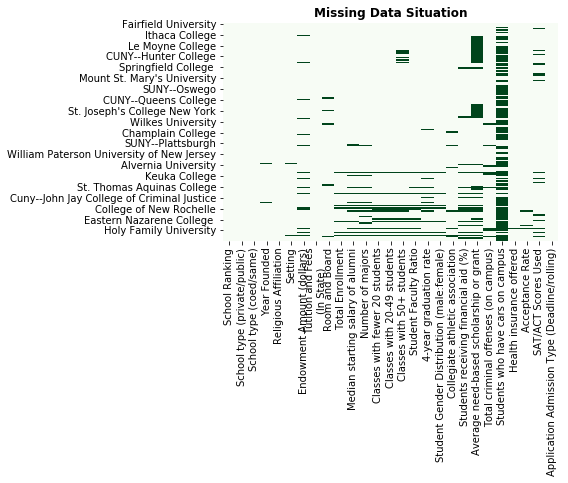

In [436]:
sns.heatmap(colleges.isnull(), cbar=False, cmap="Greens")
plt.title("Missing Data Situation", Fontweight="bold")
plt.show()

In [437]:
null_sum = colleges.isnull().sum()
not_null_sum = colleges.notnull().sum()
null_or_not_sum = pd.concat([not_null_sum, null_sum], axis=1)
null_or_not_sum = null_or_not_sum.rename(columns={0: "Total Number of Missing Data", 1:"Total Number of Non Missing Data"})

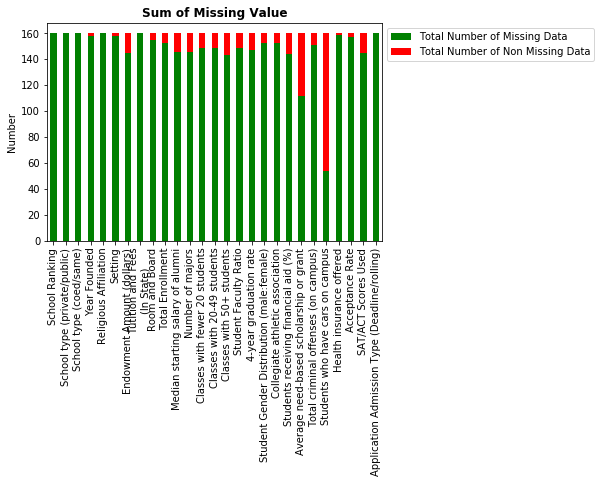

In [438]:
null_or_not_sum.plot.bar(stacked=True, color=["green", "red"])
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Sum of Missing Value", fontweight="bold")
plt.ylabel("Number")
plt.show()

In [439]:
no_missing = colleges.dropna()
print(no_missing.shape)

(37, 27)


After dropping the missing data cells, there are only 37 rows left. So the better way to deal with missing value should be fill the missing value with the mode of the column. The columns "Students who have cars on campus" only has 54 out of 160 non null values, so instead of fill the missing value, it should be better to drop this column. The column "Total criminal offenses (on campus)" seems not reliable. Some are the sum of three years, some are only the sum of 2016, some seems not be correct. So it would be better not to use the column.

In [440]:
colleges1 = colleges.copy()

__Drop Columns with many missing/incorrect data.__

In [441]:
colleges1 = colleges1.drop(["Students who have cars on campus", "Total criminal offenses (on campus)"], axis=1)

In [442]:
missing_columns = np.array(colleges1.columns[colleges1.isnull().any()])

In [443]:
missing_columns

array(['Year Founded', 'Setting', 'Endowment Amount (dollars)',
       'Room and Board', 'Total Enrollment',
       'Median starting salary of alumni', 'Number of majors',
       'Classes with fewer 20 students', 'Classes with 20-49 students',
       'Classes with 50+ students', 'Student Faculty Ratio',
       '4-year graduation rate',
       'Student Gender Distribution (male:female)',
       'Collegiate athletic association',
       'Students receiving financial aid (%)',
       'Average need-based scholarship or grant',
       'Health insurance offered', 'Acceptance Rate',
       'SAT/ACT Scores Used'], dtype=object)

In [444]:
len(missing_columns)

19

21 columns as shown above have missing value(s).

__Fill the missing values with the mode of the column.__

In [445]:
for column_name in missing_columns:
    #print(column_name)
    colleges1[str(column_name)].fillna(colleges1[str(column_name)].mode()[0], inplace=True)

In [446]:
colleges1.columns[colleges1.isnull().any()]

Index([], dtype='object')

In [447]:
colleges1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, Fairfield University to New England College
Data columns (total 25 columns):
School Ranking                                   160 non-null int64
School type (private/public)                     160 non-null category
School type (coed/same)                          160 non-null category
Year Founded                                     160 non-null float64
Religious Affiliation                            160 non-null category
Setting                                          160 non-null category
Endowment Amount (dollars)                       160 non-null float64
Tutition and Fees
(In State)                     160 non-null float64
Room and Board                                   160 non-null float64
Total Enrollment                                 160 non-null float64
Median starting salary of alumni                 160 non-null float64
Number of majors                                 160 non-null float64
Classes with fewer 20 s

__Now the dataframe colleges1 has 25 columns with no mossing value.__

### Correlation Matrix

The correlation matrix is to compute the correlation coefficient and find out the highly correlated variable pairs.

First, convert categorical data into numeric.

In [448]:
colleges2 = colleges1.copy()

In [449]:
cat_columns = colleges2.select_dtypes(['category']).columns

In [450]:
cat_columns

Index([u'School type (private/public)', u'School type (coed/same)',
       u'Religious Affiliation', u'Setting',
       u'Collegiate athletic association', u'Health insurance offered',
       u'SAT/ACT Scores Used',
       u'Application Admission Type (Deadline/rolling)'],
      dtype='object')

In [451]:
colleges2[cat_columns] = colleges2[cat_columns].apply(lambda x: x.cat.codes)

In [452]:
colleges2.head()

,School Ranking,School type (private/public),School type (coed/same),Year Founded,Religious Affiliation,Setting,Endowment Amount (dollars),Tutition and Fees (In State),Room and Board,Total Enrollment,Median starting salary of alumni,Number of majors,Classes with fewer 20 students,Classes with 20-49 students,Classes with 50+ students,Student Faculty Ratio,4-year graduation rate,Student Gender Distribution (male:female),Collegiate athletic association,Students receiving financial aid (%),Average need-based scholarship or grant,Health insurance offered,Acceptance Rate,SAT/ACT Scores Used,Application Admission Type (Deadline/rolling)
Fairfield University,1,0,0,1942.00,8,2,349300000.00,48350.00,14710.00,5192.00,55600.00,40.00,0.44,0.55,0.01,12.00,0.79,0.69,1,0.45,27572.00,1,0.65,1,0
Providence College,2,0,0,1917.00,8,0,221100000.00,50390.00,14700.00,4306.00,53300.00,50.00,0.54,0.44,0.00,12.00,0.80,0.82,1,0.47,27621.00,1,0.52,1,0
Bentley University,3,0,0,1917.00,4,2,27180000.00,49880.00,16320.00,4272.00,61500.00,11.00,0.19,0.81,0.01,11.00,0.87,1.44,2,0.44,32947.00,1,0.44,1,0
College of New Jersey,4,1,0,1855.00,4,2,37400000.00,16551.00,13617.00,7552.00,55000.00,10.00,0.44,0.56,0.00,13.00,0.73,0.72,3,0.50,11601.00,1,0.48,1,0
Loyola University Maryland,5,0,0,1852.00,8,3,214900000.00,49085.00,14430.00,5783.00,55000.00,30.00,0.47,0.53,0.00,11.00,0.77,0.72,1,0.53,21247.00,1,0.75,1,0


In [453]:
predictors = colleges2.iloc[:,1:]

In [454]:
predictors_names = np.array(predictors.columns)

In [455]:
predictors_names

array(['School type (private/public)', 'School type (coed/same)',
       'Year Founded', 'Religious Affiliation', 'Setting',
       'Endowment Amount (dollars)', 'Tutition and Fees\n(In State)',
       'Room and Board', 'Total Enrollment',
       'Median starting salary of alumni', 'Number of majors',
       'Classes with fewer 20 students', 'Classes with 20-49 students',
       'Classes with 50+ students', 'Student Faculty Ratio',
       '4-year graduation rate',
       'Student Gender Distribution (male:female)',
       'Collegiate athletic association',
       'Students receiving financial aid (%)',
       'Average need-based scholarship or grant',
       'Health insurance offered', 'Acceptance Rate',
       'SAT/ACT Scores Used',
       'Application Admission Type (Deadline/rolling)'], dtype=object)

In [456]:
names = np.array([x.split()[0] for x in predictors_names])
names[0] = "Private"
names[1] = "Coed"
names[11] = "fewer 20"
names[12] = "20-49"
names[13] = "50+"

In [457]:
correlations = predictors.corr()

In [458]:
pd.set_option("display.max_rows", 1000)
print(correlations.abs().unstack().sort_values(kind="quicksort", ascending=False))

Application Admission Type (Deadline/rolling)  Application Admission Type (Deadline/rolling)   1.00
Classes with fewer 20 students                 Classes with fewer 20 students                  1.00
Health insurance offered                       Health insurance offered                        1.00
Average need-based scholarship or grant        Average need-based scholarship or grant         1.00
Students receiving financial aid (%)           Students receiving financial aid (%)            1.00
Collegiate athletic association                Collegiate athletic association                 1.00
Student Gender Distribution (male:female)      Student Gender Distribution (male:female)       1.00
4-year graduation rate                         4-year graduation rate                          1.00
Student Faculty Ratio                          Student Faculty Ratio                           1.00
Classes with 50+ students                      Classes with 50+ students                       1.00


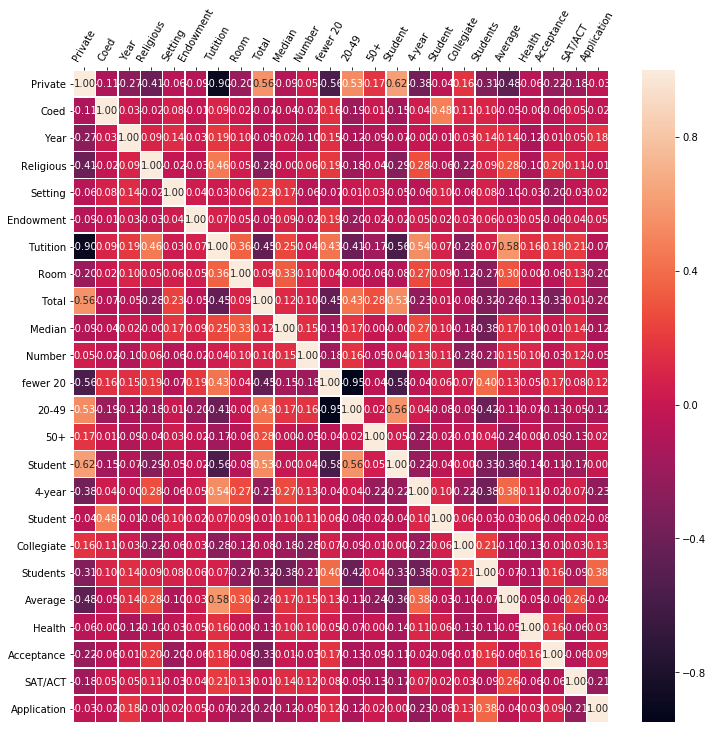

In [459]:
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(correlations, annot=True, linewidths=.5, fmt= '.2f',ax=ax)
ax.xaxis.tick_top()
ax.set_xticklabels(names, rotation=60)
ax.set_yticklabels(names)
plt.show()

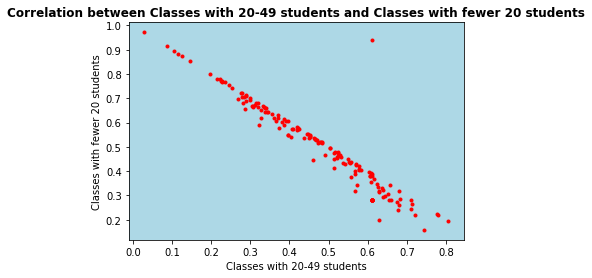

In [460]:
ax = colleges2.plot(x="Classes with 20-49 students", y="Classes with fewer 20 students", style='.', color="red")
ax.set_facecolor('lightblue')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Correlation between Classes with 20-49 students and Classes with fewer 20 students", fontweight="bold")
plt.ylabel("Classes with fewer 20 students")
ax.get_legend().remove()
plt.show()

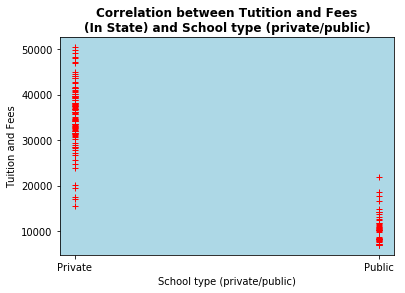

In [461]:
ax = colleges2.plot(x="School type (private/public)", y="Tutition and Fees\n(In State)", style='+', color="red")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Correlation between Tutition and Fees\n(In State) and School type (private/public)", fontweight="bold")
plt.xticks(np.arange(0, 2, step=1),("Private", "Public"))
plt.ylabel("Tuition and Fees")
ax.get_legend().remove()
ax.set_facecolor('lightblue')
plt.show()

From the correlation matrix chart and heat map, we can see that the two variabe pairs - "Classes with 20-49 students" and "Classes with fewer 20 students", "Tutition and Fees\n(In State)" and "School type (private/public)"are highly correlated, with correlation value of 0.949784, 0.896943 respectively. Thus, in these two variable paris only one variable of each pair should be selected. In this project, I drop "Classes with fewer 20 students" and "School type (private/public)". 

In [462]:
colleges3 = colleges2.copy()
colleges3 = colleges3.drop(["Classes with fewer 20 students", "School type (private/public)"], 
                           axis=1)

In [463]:
colleges3.shape

(160, 23)

The data set colleges3 has 160 rows and 23 columns. The three columns "Classes with fewer 20 students", "School type (private/public)", "Student Faculty Ratio" has been removed.

### Significance of Predictor Variables

In this part, f_regression is used. F_regression is univariate linear regression tests. This is done in 2 steps:
1. The correlation between each regressor and the target is computed.
2. It is converted to an F score then to a p-value.

In [464]:
array = colleges3.values

In [465]:
X = array[:,1:23]
y = array[:,0]

In [466]:
k=5
feat_selector = SelectKBest(f_regression, k=k)
_ = feat_selector.fit(X, y)
feat_scores = pd.DataFrame()
feat_scores["Predictor_Variable"] = colleges3.drop("School Ranking", axis=1).columns
feat_scores["F_Score"] = feat_selector.scores_
feat_scores["P_Value"] = feat_selector.pvalues_
#feat_scores["Support"] = feat_selector.get_support()

In [467]:
feat_scores

,Predictor_Variable,F_Score,P_Value
0,School type (coed/same),0.17,0.68
1,Year Founded,1.61,0.21
2,Religious Affiliation,4.19,0.04
3,Setting,0.99,0.32
4,Endowment Amount (dollars),0.23,0.64
5,Tutition and Fees\n(In State),17.75,0.00
6,Room and Board,25.79,0.00
7,Total Enrollment,4.66,0.03
8,Median starting salary of alumni,29.76,0.00
9,Number of majors,11.96,0.00


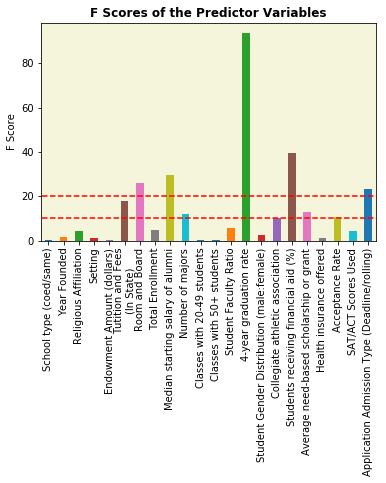

In [468]:
fig, ax = plt.subplots()
ax = feat_scores["F_Score"].plot(kind="bar")
ax.plot([-0.4, len(feat_scores.index)], [20, 20], "--", color="red")
ax.plot([-0.4, len(feat_scores.index)], [10, 10], "--", color="red")
loc=range(len(feat_scores.index))
labels=feat_scores["Predictor_Variable"].values
ax.set_xticks(loc)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("F Score")
plt.title("F Scores of the Predictor Variables", fontweight="bold")
ax.set_facecolor('beige')
plt.show()

The F score shows the correaltion between each predictor variable and the response variable. The larger the F score, the stronger correlation. The F scores among the variables can be group by the threshold of 20. There are 5 of them above 20, so I set the k in the previous cell into 5.

In [469]:
features_f20 = feat_scores[feat_scores["F_Score"]>=20]["Predictor_Variable"].values
features_f20

array(['Room and Board', 'Median starting salary of alumni',
       '4-year graduation rate', 'Students receiving financial aid (%)',
       'Application Admission Type (Deadline/rolling)'], dtype=object)

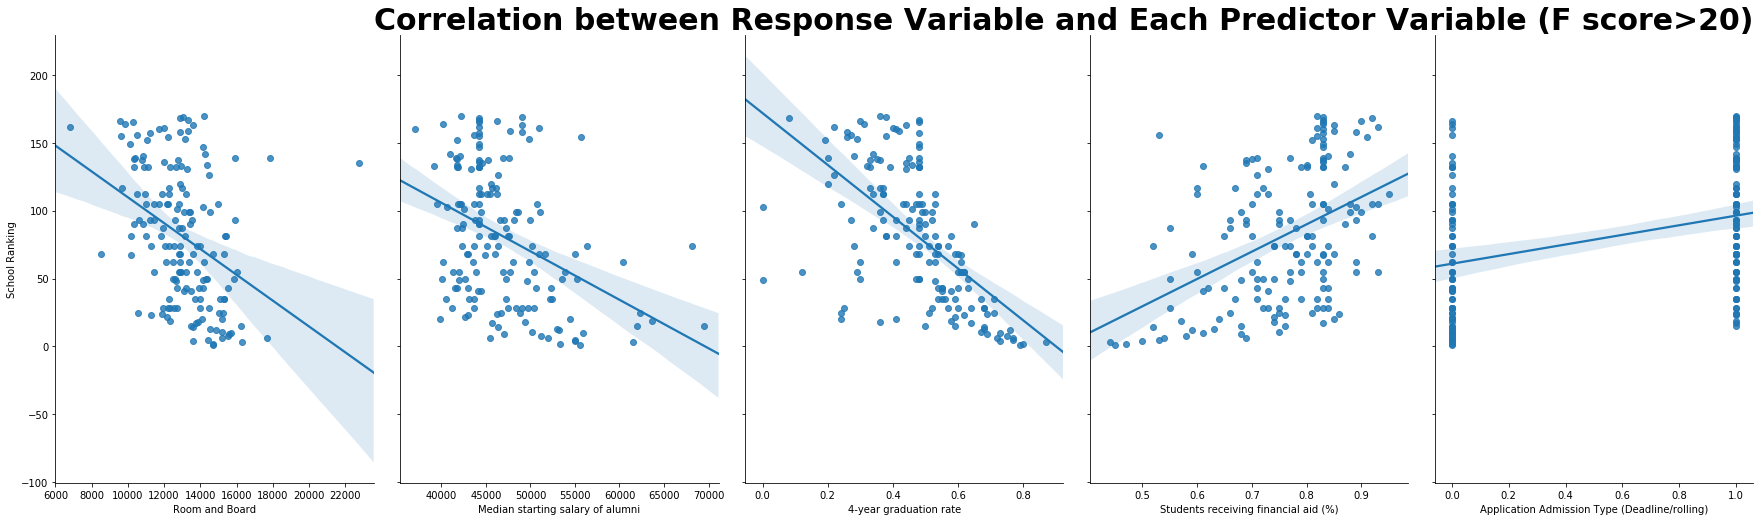

In [470]:
sns.pairplot(colleges3, x_vars=features_f20, y_vars='School Ranking', size=7, aspect=0.7, kind='reg')
plt.title("Correlation between Response Variable and Each Predictor Variable (F score>20)", fontweight="bold", 
          fontsize=30, loc='right')
plt.show()

In [471]:
features_f10 = feat_scores[feat_scores["F_Score"]>=10]["Predictor_Variable"].values
features_f10

array(['Tutition and Fees\n(In State)', 'Room and Board',
       'Median starting salary of alumni', 'Number of majors',
       '4-year graduation rate', 'Collegiate athletic association',
       'Students receiving financial aid (%)',
       'Average need-based scholarship or grant', 'Acceptance Rate',
       'Application Admission Type (Deadline/rolling)'], dtype=object)

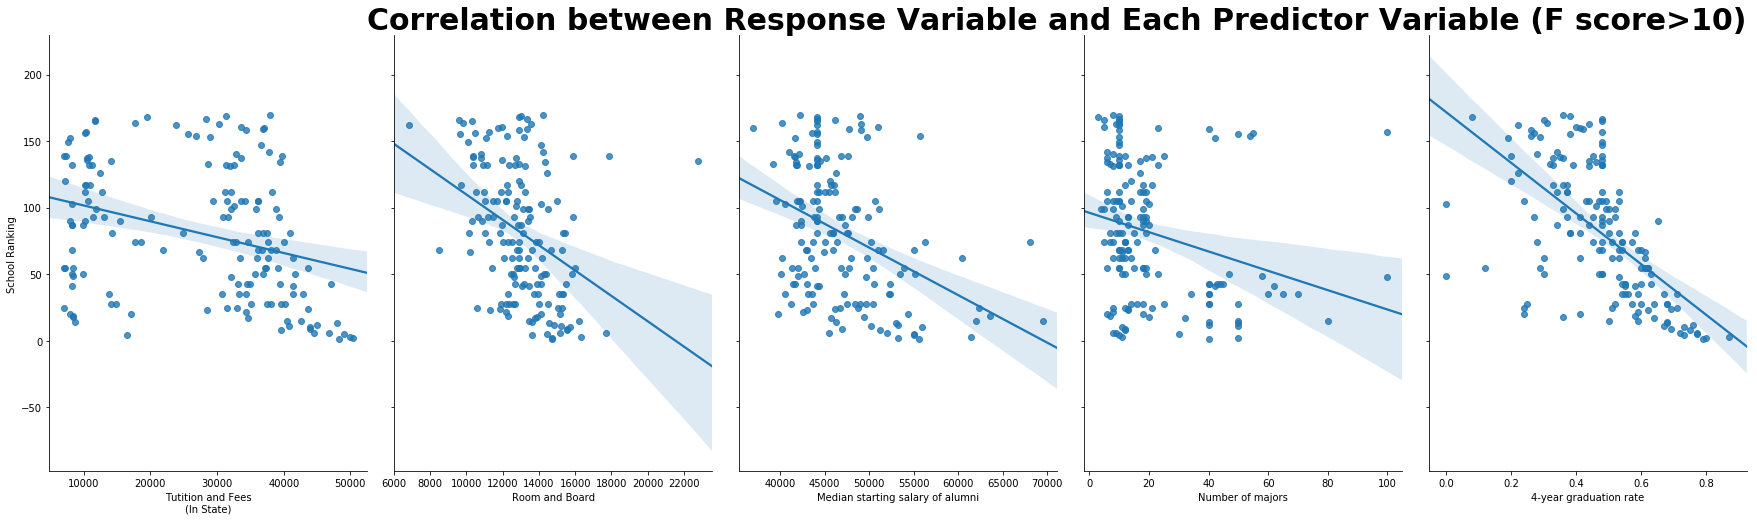

In [472]:
sns.pairplot(colleges3, x_vars=features_f10[0:5], y_vars='School Ranking', size=7, aspect=0.7, kind='reg')
plt.title("Correlation between Response Variable and Each Predictor Variable (F score>10)", fontweight="bold", 
          fontsize=30, loc='right')
plt.show()

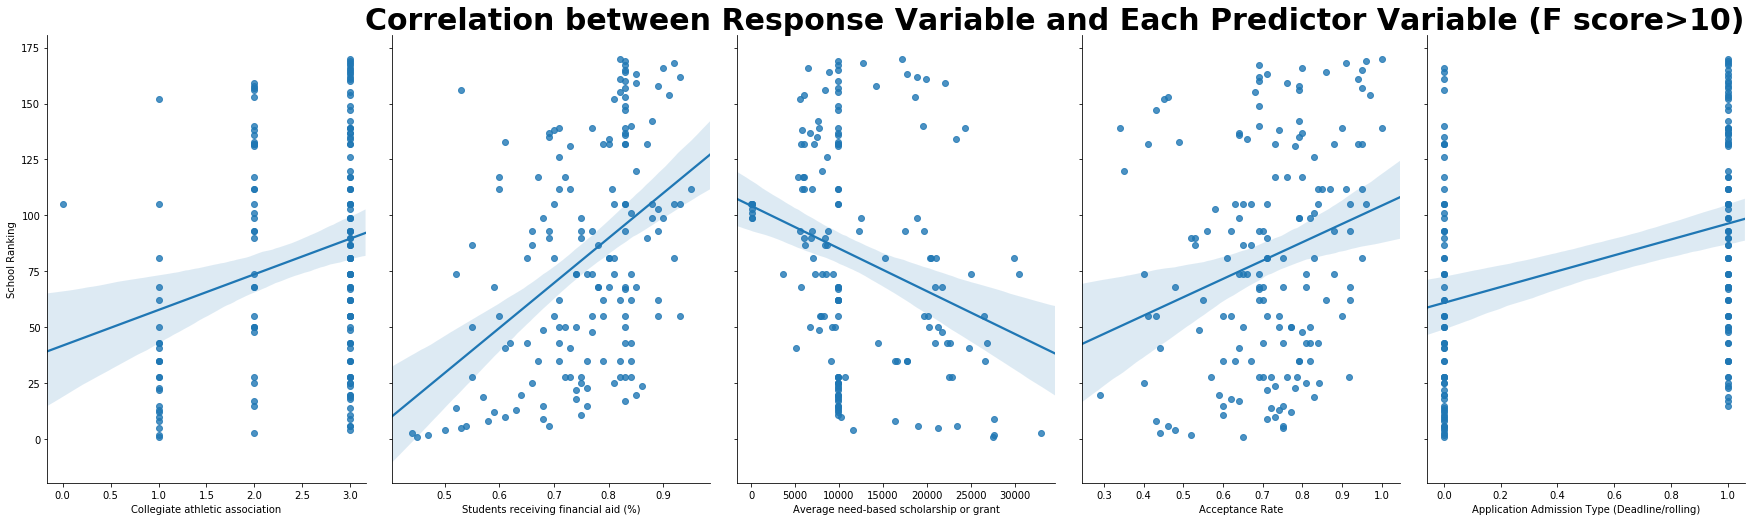

In [473]:
sns.pairplot(colleges3, x_vars=features_f10[5:], y_vars='School Ranking', size=7, aspect=0.7, kind='reg')
plt.title("Correlation between Response Variable and Each Predictor Variable (F score>10)", fontweight="bold", 
          fontsize=30, loc='right')
plt.show()

# Regression Model

Regression model from features with 20 or above F score.

In [474]:
X_f20_train, X_f20_test, y_f20_train, y_f20_test = train_test_split(
    colleges3[features_f20].values, y, random_state=42, test_size=0.2)

model_f20 = sm.OLS(y_f20_train, X_f20_train).fit()
predictions20 = model_f20.predict(X_f20_test)

Regression model from features with 10 or above F score.

In [475]:
X_f10_train, X_f10_test, y_f10_train, y_f10_test = train_test_split(
    colleges3[features_f10].values, y, random_state=42, test_size=0.2)

model_f10 = sm.OLS(y_f10_train, X_f10_train).fit()
predictions10 = model_f10.predict(X_f10_test) 

Regression model with all features.

In [476]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    X, y, random_state=42, test_size=0.2)

model_all = sm.OLS(y_all_train, X_all_train).fit()
predictions_all = model_all.predict(X_all_test) 

In [477]:
evaluation = pd.DataFrame()
evaluation["True_Ranking"] = y_f10_test.astype(int)
evaluation["Prediction_Ranking(F>20)"] = predictions20.astype(int)
evaluation["Prediction_Ranking(F>10)"] = predictions10.astype(int)
evaluation["Prediction_Ranking(all)"] = predictions_all.astype(int)
evaluation.head()

,True_Ranking,Prediction_Ranking(F>20),Prediction_Ranking(F>10),Prediction_Ranking(all)
0,105,88,67,88
1,105,96,99,87
2,152,136,100,123
3,55,157,120,51
4,93,110,88,83


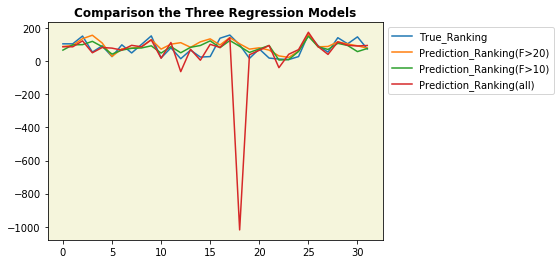

In [478]:
ax=evaluation.plot()
ax.set_facecolor("beige")
plt.title("Comparison the Three Regression Models", fontweight="bold")
ax.legend(bbox_to_anchor=[1,1])
plt.show()

In [479]:
evaluation_adjust = evaluation[evaluation["Prediction_Ranking(all)"]>0]

Remove the below 0 points and replot.

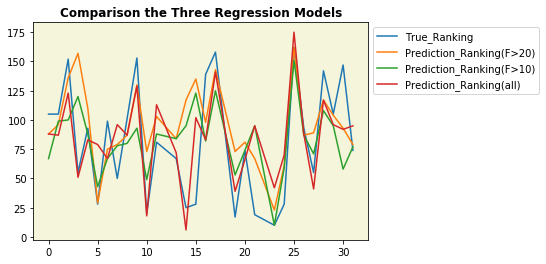

In [480]:
ax=evaluation_adjust.plot()
ax.set_facecolor("beige")
plt.title("Comparison the Three Regression Models", fontweight="bold")
ax.legend(bbox_to_anchor=[1,1])
plt.show()

In [481]:
rmse_f20 = np.sqrt(metrics.mean_squared_error(y_f20_test,predictions20))
rmse_f10 = np.sqrt(metrics.mean_squared_error(y_f10_test,predictions10))
rmse_all = np.sqrt(metrics.mean_squared_error(y_all_test,predictions_all))
rmse = pd.DataFrame([[rmse_f20, rmse_f10, rmse_all]], columns=["model (F score >20)", "model (F score >10)", "model (all)"],
                    index=["rmse"])
rmse

,model (F score >20),model (F score >10),model (all)
rmse,43.52,40.67,200.87


RMSE: Root Mean Square Error. The model made by vairables with F score >10 is slightly better.

# Classification Model

Create a class label. Devide school rankings into top 10, top 30, top 60, top 100 and others.

In [494]:
colleges4 = colleges3.copy()

for schoolname, schoolranking in colleges4["School Ranking"].iteritems():
    if schoolranking <= 10:
        colleges4.loc[schoolname, "Class"] = "Top 10"
    elif schoolranking <= 30:
        colleges4.loc[schoolname, "Class"] = "Top 30"
    elif schoolranking <= 60:
        colleges4.loc[schoolname, "Class"] = "Top 60"
    elif schoolranking <= 100:
        colleges4.loc[schoolname, "Class"] = "Top 100"
    else:
        colleges4.loc[schoolname, "Class"] = "Others"
        
colleges4["Class"] = colleges4["Class"].astype("category")

In [495]:
colleges4["Class"].unique()

[Top 10, Top 30, Top 60, Top 100, Others]
Categories (5, object): [Top 10, Top 30, Top 60, Top 100, Others]

In [496]:
array4 = colleges4.values
y_class = array4[:, 23]
X_class = array4[:, 1:23]
#y_class

In [497]:
k=6
feat_selector4 = SelectKBest(chi2, k=k)
_ = feat_selector4.fit(X_class, y_class)
feat_scores4 = pd.DataFrame()
feat_scores4["Predictor_Variable"] = colleges4.drop(["School Ranking", "Class"], axis=1).columns
feat_scores4["F_Score"] = feat_selector4.scores_
feat_scores4["P_Value"] = feat_selector4.pvalues_
feat_scores4["Support"] = feat_selector4.get_support()
pd.set_option("display.float_format",  "{:.2f}".format)
feat_scores4

,Predictor_Variable,F_Score,P_Value,Support
0,School type (coed/same),1.40,0.84,False
1,Year Founded,3.19,0.53,False
2,Religious Affiliation,9.24,0.06,False
3,Setting,0.62,0.96,False
4,Endowment Amount (dollars),11269642458.35,0.00,True
5,Tutition and Fees\n(In State),139713.07,0.00,True
6,Room and Board,8035.79,0.00,True
7,Total Enrollment,11850.06,0.00,True
8,Median starting salary of alumni,22183.86,0.00,True
9,Number of majors,574.85,0.00,False


In [498]:
features_chosen_names = feat_scores4[feat_scores4["Support"]==True][["Predictor_Variable"]].values
features_chosen_names

array([['Endowment Amount (dollars)'],
       ['Tutition and Fees\n(In State)'],
       ['Room and Board'],
       ['Total Enrollment'],
       ['Median starting salary of alumni'],
       ['Average need-based scholarship or grant']], dtype=object)

The above six features are chosen.

In [499]:
features_chosen = feat_selector4.transform(X_class)
pd.DataFrame(features_chosen, columns=features_chosen_names).head()

,"(Endowment Amount (dollars),)","(Tutition and Fees (In State),)","(Room and Board,)","(Total Enrollment,)","(Median starting salary of alumni,)","(Average need-based scholarship or grant,)"
0,349300000.00,48350.00,14710.00,5192.00,55600.00,27572.00
1,221100000.00,50390.00,14700.00,4306.00,53300.00,27621.00
2,27180000.00,49880.00,16320.00,4272.00,61500.00,32947.00
3,37400000.00,16551.00,13617.00,7552.00,55000.00,11601.00
4,214900000.00,49085.00,14430.00,5783.00,55000.00,21247.00


In [500]:
X_class_train1, X_class_test1, y_class_train1, y_class_test1 = train_test_split(
    features_chosen, y_class, random_state=123,test_size=0.2)

model_class1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_class_train1, y_class_train1)
predictions_class1 = model_class1.predict(X_class_test1)

In [501]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, random_state=123, test_size=0.2)

model_class = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0).fit(X_class_train, y_class_train)
predictions_class = model_class.predict(X_class_test)

In [505]:
evaluation_class = pd.DataFrame()
evaluation_class["True_Class"] = y_class_test
evaluation_class["Prediction_Class(Chosen Features)"] = predictions_class1
evaluation_class["Prediction_Class(all)"] = predictions_class
evaluation_class.head()

,True_Class,Prediction_Class(Chosen Features),Prediction_Class(all)
0,Others,Others,Others
1,Others,Others,Others
2,Others,Others,Others
3,Top 100,Others,Others
4,Top 30,Top 60,Top 60


In [515]:
accuracy1 = metrics.accuracy_score(y_class_test, predictions_class1)
accuracy = metrics.accuracy_score(y_class_test, predictions_class)
pd.DataFrame([[accuracy1, accuracy]], columns=["Model (Chosen Features)", "Model (All Features)"], index=["Accuracy"])

,Model (Chosen Features),Model (All Features)
Accuracy,0.34,0.38


The model made of all features is slightly better.

__Answer the potential questions.__

1. In the classifier model, I use random forest with pre-pruning by setting max_depth to 2. The reason why I choose prepruning is to prevent overfitting.
2. The models have low accuray rate. Reason: One is due to how I categorize the school ranking. If I divide it into below 80 and above 80, the accuracy is better. In the project, I categorize it into top 10, top 30, top 60, top 100 and others. In this case, it would be harder to classify.
3. The regression models seem better than the classification models. Because the prior predict exact ranking, and the results are not too bad.